In [ ]:
# imports
import pandas as pd
import torch
import numpy as np
import sys
import os
from scipy import stats
from evoaug_utils.model_zoo import DeepSTARR
from distill_EvoAug2 import UncertaintyAwareStudent, UncertaintyAwareLightningModel
from tangermeme.utils import one_hot_encode
from tangermeme.predict import predict
from tangermeme.deep_lift_shap import deep_lift_shap
from tqdm import trange
import tfmodisco

In [2]:
# Check gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [72]:
def predict(model, X, args=None, func=None, batch_size=32, dtype=None, 
    device='cuda', verbose=False):
    """Make batched predictions in a memory-efficient manner.

    This function will take a PyTorch model and make predictions from it using
    the forward function, with optional additional arguments to the model. The
    additional arguments must have the same batch size as the examples, and the
    i-th example will be given to the model with the i-th index of each
    additional argument. 

    Before starting predictions, the model is moved to the specified device. As 
    predictions are being made, each batch is also moved to the specified 
    device and then moved back to the CPU after predictions are made. Each batch
    is converted to the provided dtype if provided, keeping the original blob of
    examples in the original dtype. These features allow the function to work on 
    massive data sets that do not fit in GPU memory. For example, the original
    sequences can be kept as 8-bit integers for compression and each batch will
    be upcast to the desired precision. If a single batch does not fit in memory,
    try lowering the batch size.


    Parameters
    ----------
    model: torch.nn.Module
        The PyTorch model to use to make predictions.

    X: torch.tensor, shape=(-1, len(alphabet), length)
        A one-hot encoded set of sequences to make predictions for.

    args: tuple or list or None, optional
        An optional set of additional arguments to pass into the model. If
        provided, each element in the tuple or list is one input to the model
        and the element must be formatted to be the same batch size as `X`. If
        None, no additional arguments are passed into the forward function.
        Default is None.

    func: function or None, optional 
        A function to apply to a batch of predictions after they have been made.
        If None, do nothing to them. Default is None.

    batch_size: int, optional
        The number of examples to make predictions for at a time. Default is 32.

    dtype: str or torch.dtype or None, optional
        The dtype to use with mixed precision autocasting. If None, use the dtype of
        the *model*. This allows you to use int8 to represent large data sets and
        only convert batches to the higher precision, saving memory. Defailt is None.

    device: str or torch.device, optional
        The device to move the model and batches to when making predictions. If
        set to 'cuda' without a GPU, this function will crash and must be set
        to 'cpu'. Default is 'cuda'. 

    verbose: bool, optional
        Whether to display a progress bar during predictions. Default is False.


    Returns
    -------
    y: torch.Tensor or list/tuple of torch.Tensors
        The output from the model for each input example. The precise format
        is determined by the model. If the model outputs a single tensor,
        y is a single tensor concatenated across all batches. If the model
        outputs multiple tensors, y is a list of tensors which are each
        concatenated across all batches.
    """

    model = model.to(device).eval()
    
    if dtype is None:
        try:
            dtype = next(model.parameters()).dtype
        except:
            dtype = torch.float32
    elif isinstance(dtype, str):
        dtype = getattr(torch, dtype)

    if args is not None:
        for arg in args:
            if arg.shape[0] != X.shape[0]:
                raise ValueError("Arguments must have the same first " +
                    "dimension as X")

    ###

    y = []
    with torch.no_grad():
        batch_size = min(batch_size, X.shape[0])

        for start in trange(0, X.shape[0], batch_size, disable=not verbose):
            end = start + batch_size
            X_ = X[start:end].type(dtype).to(device)

            if X_.shape[0] == 0:
                continue

            with torch.autocast(device_type=device, dtype=dtype):
                if args is not None:
                    args_ = [a[start:end].type(dtype).to(device) for a in args]
                    y_ = model(X_, *args_)
                else:
                    y_ = model(X_)

            # If a post-processing function is provided, apply it to the raw output
            # from the model.
            if func is not None:
                y_ = func(y_)

            # Move to the CPU
            if isinstance(y_, torch.Tensor):
                y_ = y_.cpu()
            elif isinstance(y_, (list, tuple)):
                y_ = tuple(yi.cpu() for yi in y_)
            elif isinstance(y_, dict):
                # Handle dictionary output (like your UncertaintyAwareStudent)
                y_ = {k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in y_.items()}
            else:
                raise ValueError("Cannot interpret output from model.")

            y.append(y_)

    # Concatenate the outputs
    if isinstance(y[0], torch.Tensor):
        y = torch.cat(y)
    elif isinstance(y[0], dict):
        # Handle dictionary concatenation
        y = {k: torch.cat([batch[k] for batch in y]) for k in y[0].keys()}
    else:
        y = [torch.cat(y_) for y_ in list(zip(*y))]

    return y


In [4]:
# import libraries

dev_sequences_df = pd.read_csv('Libraries/Dev_CEseek_sequences.csv')
hk_sequences_df = pd.read_csv('Libraries/Hk_CEseek_sequences.csv')

dev_sequences_df.head(10)

,ce_name,orientation,ce_sequence,endogenous_sequence,pseudo_index,log2_fc,p_value,dataset
0,"('Dref', 'GATAe', '+', '+', 5)",+,TATCGATAGATTGCGATAAC,TTACTTTATACTTGAGATAGTAGTCTATCGATAGATTGCGATAACC...,1584661,5.321928,3.162613e-04,dev
1,"('twi', 'twi', '+', '-', 6)",+,ACACATATATGTACATATGT,CAAGTGCCGCAGAAACATTTGCTGATAAAATGCAAGATTTCATAAT...,846257,36.219281,4.635498e-09,dev
2,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAG,ATTTAGCACGAGAAAACACAGATAATTGGCTATTCACAGCGACATA...,620728,4.574315,5.067241e-114,dev
3,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAG,AAAAATAGTTTTAAATAATTTTATTGAAATAGAAGTTTCAAAAAAT...,433870,4.574315,5.067241e-114,dev
4,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAC,AAAACGAAAACGTAGAGCTACCGTGCTTGGGTTCGATACTTGTGCT...,639485,4.574315,5.067241e-114,dev
5,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAG,AAAACATTTGATCAAAAACACAAATAAGAAAAATTTCCCACCATTT...,710270,4.574315,5.067241e-114,dev
6,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAC,AAAACGCAATATTCGTTTTTACATTCGCATTTGTTGCGAATAAATA...,139095,4.574315,5.067241e-114,dev
7,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAG,GCGTAACTTTGAAAGACTTTCAGAAAAATATCAATTTTTGGTTTCC...,18536,4.574315,5.067241e-114,dev
8,"('GATAe', 'Jra', '+', '+', 4)",+,AGATAAGCTAAGTGAATCATG,TGCCGTCAGATAAGCTAAGTGAATCATGCAATGAAGAGAGGCAATG...,276895,6.643856,3.851699e-10,dev
9,"('Dref', 'Dref', '+', '-', 5)",+,TATCGATAGATTCAGTCGATA,GAGTTGCAGAGCTGCGAGGAATGATTAAAGCTGCAGGCCGCTTAGA...,847311,5.906891,2.398414e-11,dev


In [ ]:
# Load EvoAug DeepSTARR student model
# Use pylightning student architecture from distill_EvoAug2.py

# Add path to Train_Oracle_Model directory for imports
sys.path.append('../Train_Oracle_Model')


# Paths
output_dir = '../Train_Oracle_Model/EvoAug_ensemble_10'
# New folder for saving outputs
selection_dir = './Libraries'
os.makedirs(selection_dir, exist_ok=True)
student_ckpt = os.path.join(output_dir, 'EvoAug_student_model.ckpt')

# Build a minimal "teacher" with just the DeepSTARR architecture (no weights)
teacher_model = type("Teacher", (), {"model": DeepSTARR(2)})()

# Build student and load trained weights
student_model = UncertaintyAwareStudent(teacher_model, num_tasks=2)
lightning_student = UncertaintyAwareLightningModel.load_from_checkpoint(student_ckpt, student_model=student_model)

# Device + eval
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lightning_student.to(device).eval()

print("Student model loaded successfully")

Student model loaded successfully


In [79]:
# Score library with EvoAug student model using efficient batched prediction

def score_library_efficient(library_df, model, batch_size=64):
    library_name = f"{library_df['dataset'].iloc[0].upper()} library"
    dataset_type = library_df['dataset'].iloc[0].lower()  # 'dev' or 'hk'
    
    # One-hot encode all sequences at once
    sequences = [one_hot_encode(seq) for seq in library_df['endogenous_sequence']]
    X = torch.stack(sequences)  # Shape: (n_sequences, 4, seq_length)
    
    # Use the predict function for efficient batched prediction
    predictions = predict(model, X, batch_size=batch_size, device=str(device), verbose=True)
    
    # Handle dictionary output (your model returns {'mean': tensor, 'uncertainty': tensor})
    if isinstance(predictions, dict):
        y_pred = predictions['mean'].numpy()
    else:
        y_pred = predictions.numpy()
    
    # Extract the correct task predictions:
    # Model outputs shape: (n_sequences, 2) where [:, 0] = dev, [:, 1] = hk
    if dataset_type == 'dev':
        task_predictions = y_pred[:, 0]  # Use dev predictions (index 0)
        print(f"Using DEV task predictions (index 0) for {library_name}")
    elif dataset_type == 'hk':
        task_predictions = y_pred[:, 1]  # Use hk predictions (index 1)
        print(f"Using HK task predictions (index 1) for {library_name}")
    else:
        raise ValueError(f"Unknown dataset type: {dataset_type}")
    
    # Add predictions to dataframe
    library_df = library_df.copy()
    library_df['EvoAug_predictions'] = task_predictions
    print(f'{library_name} scored with EvoAug student model.')
    return library_df

# Score both libraries efficiently with correct task predictions
dev_sequences_df = score_library_efficient(dev_sequences_df, lightning_student)
hk_sequences_df = score_library_efficient(hk_sequences_df, lightning_student)

100%|██████████| 5/5 [00:00<00:00, 894.19it/s]


Using DEV task predictions (index 0) for DEV library
DEV library scored with EvoAug student model.


100%|██████████| 6/6 [00:00<00:00, 1164.38it/s]

Using HK task predictions (index 1) for HK library
HK library scored with EvoAug student model.


In [80]:
# Quick summary of library scores
print("Dev Library Summary:")
print(f"     Mean: {np.mean(dev_sequences_df['EvoAug_predictions'])}")
print(f"     Mean: {np.max(dev_sequences_df['EvoAug_predictions'])}")

print("HK Library Summary:")
print(f"     Mean: {np.mean(hk_sequences_df['EvoAug_predictions'])}")
print(f"     Max: {np.max(hk_sequences_df['EvoAug_predictions'])}")



Dev Library Summary:
     Mean: 2.3985114097595215
     Mean: 5.307164192199707
HK Library Summary:
     Mean: 4.10430383682251
     Max: 7.520188808441162


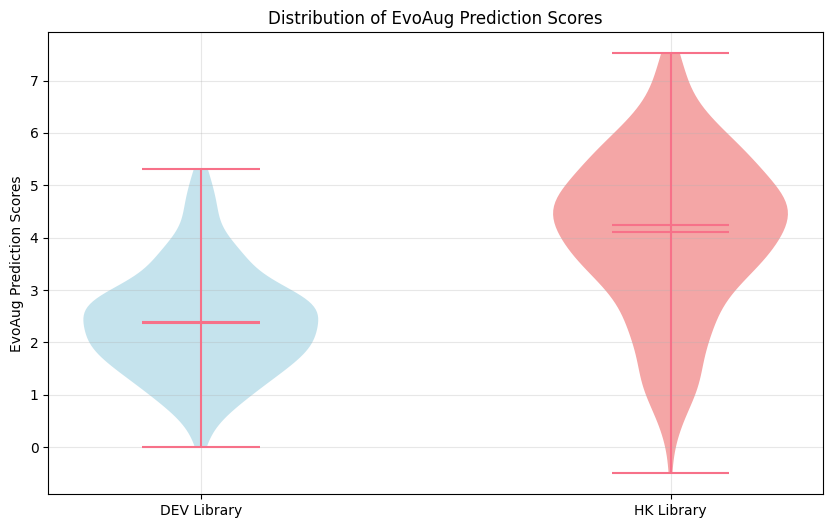

In [81]:
# Plot prediction scores for both libraries
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Prepare data for violin plots
data_to_plot = [dev_sequences_df['EvoAug_predictions'], hk_sequences_df['EvoAug_predictions']]
labels = ['DEV Library', 'HK Library']
positions = [1, 2]

# Create violin plots
violin_parts = plt.violinplot(data_to_plot, positions=positions, showmeans=True, showmedians=True)

# Color the violins
colors = ['lightblue', 'lightcoral']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

# Set x-axis labels
plt.xticks(positions, labels)
plt.ylabel('EvoAug Prediction Scores')
plt.title('Distribution of EvoAug Prediction Scores')
plt.grid(True, alpha=0.3)

# Save as SVG
plt.savefig('Libraries/prediction_scores_violin.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()


In [87]:
dev_sequences_df.sort_values(by='EvoAug_predictions', ascending=False)

,ce_name,orientation,ce_sequence,endogenous_sequence,pseudo_index,log2_fc,p_value,dataset,EvoAug_predictions
281,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAT,TATATCTGTAGCTCAACACCTGACTGCTATCGAATGTTTTGGTATT...,5585,4.574315,5.067241e-114,dev,5.307164
59,"('Jra', 'Jra', '-', '+', 10)",+,AGTGACTAATCTACTTACAAGTGAATCACG,AATCAGTTGAAATTTATACCTCATCGTCGACAATGCGAGTCGTCGC...,2590,5.321928,1.763198e-07,dev,5.268528
167,"('Dref', 'Dref', '-', '+', 4)",+,TATCGATATCACTATCGATA,TTATTAGCCGGCAAAATTGGTGGGTAAACAACAAATATTTGGACAA...,19539,38.219281,4.230561e-34,dev,5.127045
226,"('Jra', 'twi', '+', '-', 4)",+,GTGAATCACATCGACATATGT,GACTTTTCATTCCATTGTTCTTGGTTCTCGGAAGTATCAACTTATT...,626,34.219281,8.262587e-03,dev,5.113298
61,"('Dref', 'Max', '-', '+', 6)",+,TATCGATATTTGATAGCACGTG,TAATTAAGAGCAACAACAACAAACTTAGTAATGACACCCAAATAGA...,10613,35.219281,6.820836e-05,dev,5.038004
...,...,...,...,...,...,...,...,...,...
107,"('GATAe', 'GATAe', '-', '-', 10)",+,CTTATCGAATTGTTCGCATTATCG,AGCGACGCCCAACCAAGCTTATCGAATTGTTCGCATTATCGTTTAG...,1829171,5.643856,2.120598e-09,dev,0.471148
54,"('Dref', 'GATAe', '+', '+', -5)",-,TATCGATAAT,AATATCGATAATTTCATCGACTGAGCTTTTGTGGGCCAATTTGATT...,1287567,4.574315,5.067241e-114,dev,0.422376
237,"('Dref', 'Dref', '+', '+', 2)",+,TATCGAAATCTATCGATT,GCAGTAAAACTTCAACCAATCTATCGAAATCTATCGATTGTTAAGT...,1872003,35.219281,6.820836e-05,dev,0.175061
81,"('GATAe', 'GATAe', '-', '-', 10)",+,CGATAATGCGAACAATTCGATAAG,GATGCCATACGCTCCGGGCGGCTGGTAAGCTTAGTAATTACATGTC...,1973682,5.643856,2.120598e-09,dev,0.138590


In [86]:
hk_sequences_df.sort_values(by='EvoAug_predictions', ascending=False)

,ce_name,orientation,ce_sequence,endogenous_sequence,pseudo_index,log2_fc,p_value,dataset,EvoAug_predictions
67,"('Dref', 'Max', '-', '+', 6)",+,TATCGATATTTGATAGCACGTG,TAATTAAGAGCAACAACAACAAACTTAGTAATGACACCCAAATAGA...,4637,35.219281,6.817735e-05,hk,7.520189
306,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAT,TATATCTGTAGCTCAACACCTGACTGCTATCGAATGTTTTGGTATT...,605,6.174824,3.293969e-316,hk,7.510352
193,"('Dref', 'Dref', '-', '+', 4)",+,TATCGATATCACTATCGATA,TTATTAGCCGGCAAAATTGGTGGGTAAACAACAAATATTTGGACAA...,17547,38.678713,1.131588e-46,hk,7.450040
125,"('Dref', 'Dref', '-', '+', 1)",+,ATTCGATACTATCGATA,TGAGAGTAATTTACCTTTTAAAACACTTGAAAAGGTTTTAAACACG...,133078,38.804243,7.311219e-51,hk,7.195486
72,"('Dref', 'Jra', '+', '+', -3)",+,TATCGATTACTCAGC,CGAGTTTAATTTAATTTCAGTTTCTGTTTCGACACGAGCAGTCAGC...,207805,5.321928,3.161250e-04,hk,7.171366
...,...,...,...,...,...,...,...,...,...
173,"('CTCF', 'Max', '-', '-', -2)",+,GAGCCACCCACATGGA,TATTTAAGGCGGATGCATCGGAAATAAACTAAAGCGAACAAAATAC...,1372703,34.219281,8.261961e-03,hk,0.512182
163,"('GATAe', 'GATAe', '+', '+', 0)",+,CGATAACTGATAAG,TTTGTTGTTGTTGTTTTTGTTGCTGGTCTTCTACTATCTGTGTATC...,1460863,4.321928,8.797089e-04,hk,0.506145
206,"('Jra', 'twi', '-', '-', -3)",+,GGTGAGTCATCTGT,GCGGCGGGAGCGGGACAGCGAGCGGCTAGCTTTTTTTTTTTATTAT...,1357262,3.514573,1.656108e-05,hk,0.429725
40,"('twi', 'twi', '+', '-', 9)",+,ACAGATGTGACATTAATATGTGT,TGCTCGCTGCTCTTGTTCTTCCTCGACGGTCCCCAAATGCCATTCG...,1375164,34.219281,8.261961e-03,hk,0.285233


In [139]:
# PyTorch implementation inspired by SEAM Attributer
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

class PyTorchAttributer:
    """
    PyTorch version of attribution methods inspired by SEAM Attributer
    """
    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()
        
    def saliency_maps(self, X, target_idx=0, batch_size=16):
        """
        Calculate saliency maps (input × gradients)
        """
        attributions = []
        
        for i in range(0, len(X), batch_size):
            batch_X = X[i:i+batch_size].clone().detach().requires_grad_(True).to(self.device)
            
            # Forward pass
            outputs = self.model(batch_X)
            
            # Get target output
            if isinstance(outputs, dict):
                target_output = outputs['mean'][:, target_idx]
            else:
                target_output = outputs[:, target_idx]
            
            # Calculate gradients
            grads = torch.autograd.grad(
                outputs=target_output.sum(),
                inputs=batch_X,
                create_graph=False,
                retain_graph=False
            )[0]
            
            # Multiply by input (saliency map)
            saliency = batch_X * grads
            attributions.append(saliency.detach().cpu())
            
        return torch.cat(attributions, dim=0)
    
    def integrated_gradients(self, X, target_idx=0, baseline_type='zeros', 
                           num_steps=100, batch_size=8):
        """
        Calculate Integrated Gradients
        """
        attributions = []
        
        for i in range(0, len(X), batch_size):
            batch_X = X[i:i+batch_size].to(self.device)
            batch_size_actual = batch_X.shape[0]
            
            # Create baselines
            if baseline_type == 'zeros':
                baselines = torch.zeros_like(batch_X)
            elif baseline_type == 'random_shuffle':
                baselines = torch.stack([
                    batch_X[j, torch.randperm(batch_X.shape[1]), :] 
                    for j in range(batch_size_actual)
                ])
            else:
                baselines = torch.zeros_like(batch_X)
            
            # Create path
            alphas = torch.linspace(0, 1, num_steps + 1).to(self.device)
            path_inputs = []
            
            for alpha in alphas:
                path_inputs.append(baselines + alpha * (batch_X - baselines))
            
            path_inputs = torch.cat(path_inputs, dim=0)
            path_inputs.requires_grad_(True)
            
            # Calculate gradients along path
            outputs = self.model(path_inputs)
            
            if isinstance(outputs, dict):
                target_output = outputs['mean'][:, target_idx]
            else:
                target_output = outputs[:, target_idx]
            
            grads = torch.autograd.grad(
                outputs=target_output.sum(),
                inputs=path_inputs,
                create_graph=False,
                retain_graph=False
            )[0]
            
            # Reshape gradients and compute integrated gradients
            grads = grads.view(num_steps + 1, batch_size_actual, *batch_X.shape[1:])
            
            # Trapezoidal rule
            integrated_grads = torch.trapz(grads, alphas, dim=0)
            integrated_grads = integrated_grads * (batch_X - baselines)
            
            attributions.append(integrated_grads.detach().cpu())
            
        return torch.cat(attributions, dim=0)
    
    def smoothgrad(self, X, target_idx=0, num_samples=50, noise_std=0.1, batch_size=8):
        """
        Calculate SmoothGrad attributions
        """
        attributions = []
        
        for i in range(0, len(X), batch_size):
            batch_X = X[i:i+batch_size].to(self.device)
            batch_size_actual = batch_X.shape[0]
            
            batch_attributions = []
            
            for _ in range(num_samples):
                # Add noise
                noise = torch.randn_like(batch_X) * noise_std
                noisy_X = batch_X + noise
                noisy_X.requires_grad_(True)
                
                # Forward pass
                outputs = self.model(noisy_X)
                
                if isinstance(outputs, dict):
                    target_output = outputs['mean'][:, target_idx]
                else:
                    target_output = outputs[:, target_idx]
                
                # Calculate gradients
                grads = torch.autograd.grad(
                    outputs=target_output.sum(),
                    inputs=noisy_X,
                    create_graph=False,
                    retain_graph=False
                )[0]
                
                # Multiply by input
                saliency = noisy_X * grads
                batch_attributions.append(saliency.detach())
            
            # Average over samples
            avg_attributions = torch.stack(batch_attributions).mean(dim=0)
            attributions.append(avg_attributions.cpu())
            
        return torch.cat(attributions, dim=0)

# Create attributer and verify output indices
attributer = PyTorchAttributer(wrapped_model, device=device)

# Verify the model output structure first
sample_seq = dev_sequences_df['endogenous_sequence'].iloc[0]
sample_X = one_hot_encode(sample_seq).unsqueeze(0).float().to(device)
with torch.no_grad():
    test_output = wrapped_model(sample_X)
    print(f"Model output shape: {test_output.shape}")
    print(f"Model output: {test_output}")
    print("Index 0 (DEV):", test_output[0, 0].item())
    print("Index 1 (HK):", test_output[0, 1].item())

# Calculate for DEV library - using target_idx=0 for DEV task
dev_sequences = torch.stack([one_hot_encode(seq) for seq in dev_sequences_df['endogenous_sequence']]).float()
dev_attributions = attributer.integrated_gradients(dev_sequences, target_idx=0, num_steps=100, batch_size=8)

# Calculate for HK library - using target_idx=1 for HK task
hk_sequences = torch.stack([one_hot_encode(seq) for seq in hk_sequences_df['endogenous_sequence']]).float()
hk_attributions = attributer.integrated_gradients(hk_sequences, target_idx=1, num_steps=100, batch_size=8)

# Convert to numpy arrays
dev_attr_np = dev_attributions.numpy()
hk_attr_np = hk_attributions.numpy()
dev_ohe_np = dev_sequences.numpy()
hk_ohe_np = hk_sequences.numpy()

# Create output directories
import os
os.makedirs('Libraries/dev_modisco', exist_ok=True)
os.makedirs('Libraries/hk_modisco', exist_ok=True)

# Save in TF-MoDISco format (.npz files with specific keys)
# For DEV library
np.savez_compressed('Libraries/dev_modisco/attr.npz', 
                    dev=dev_attr_np)  # key = task name, value = attributions

np.savez_compressed('Libraries/dev_modisco/ohe.npz', 
                    dev=dev_ohe_np)   # key = task name, value = one-hot encoded sequences

# For HK library  
np.savez_compressed('Libraries/hk_modisco/attr.npz', 
                    hk=hk_attr_np)    # key = task name, value = attributions

np.savez_compressed('Libraries/hk_modisco/ohe.npz', 
                    hk=hk_ohe_np)     # key = task name, value = one-hot encoded sequences

print(f"DEV attributions shape: {dev_attr_np.shape}")
print(f"HK attributions shape: {hk_attr_np.shape}")
print(f"DEV one-hot shape: {dev_ohe_np.shape}")
print(f"HK one-hot shape: {hk_ohe_np.shape}")

# Verify the saved files
print("\nVerifying saved files:")
dev_attr_check = np.load('Libraries/dev_modisco/attr.npz')
dev_ohe_check = np.load('Libraries/dev_modisco/ohe.npz')

for key in dev_attr_check.files:
    print(f"DEV attribution scores key '{key}': {dev_attr_check[key].shape}")

for key in dev_ohe_check.files:
    print(f"DEV one-hot encoding key '{key}': {dev_ohe_check[key].shape}")

hk_attr_check = np.load('Libraries/hk_modisco/attr.npz')
hk_ohe_check = np.load('Libraries/hk_modisco/ohe.npz')

for key in hk_attr_check.files:
    print(f"HK attribution scores key '{key}': {hk_attr_check[key].shape}")

for key in hk_ohe_check.files:
    print(f"HK one-hot encoding key '{key}': {hk_ohe_check[key].shape}")

Model output shape: torch.Size([1, 2])
Model output: tensor([[1.7318, 4.1212]], device='cuda:0')
Index 0 (DEV): 1.7318358421325684
Index 1 (HK): 4.121178150177002
DEV attributions shape: (302, 4, 249)
HK attributions shape: (336, 4, 249)
DEV one-hot shape: (302, 4, 249)
HK one-hot shape: (336, 4, 249)

Verifying saved files:
DEV attribution scores key 'dev': (302, 4, 249)
DEV one-hot encoding key 'dev': (302, 4, 249)
HK attribution scores key 'hk': (336, 4, 249)
HK one-hot encoding key 'hk': (336, 4, 249)


Text(0.5, 1.0, 'Integrated Gradients Attribution')

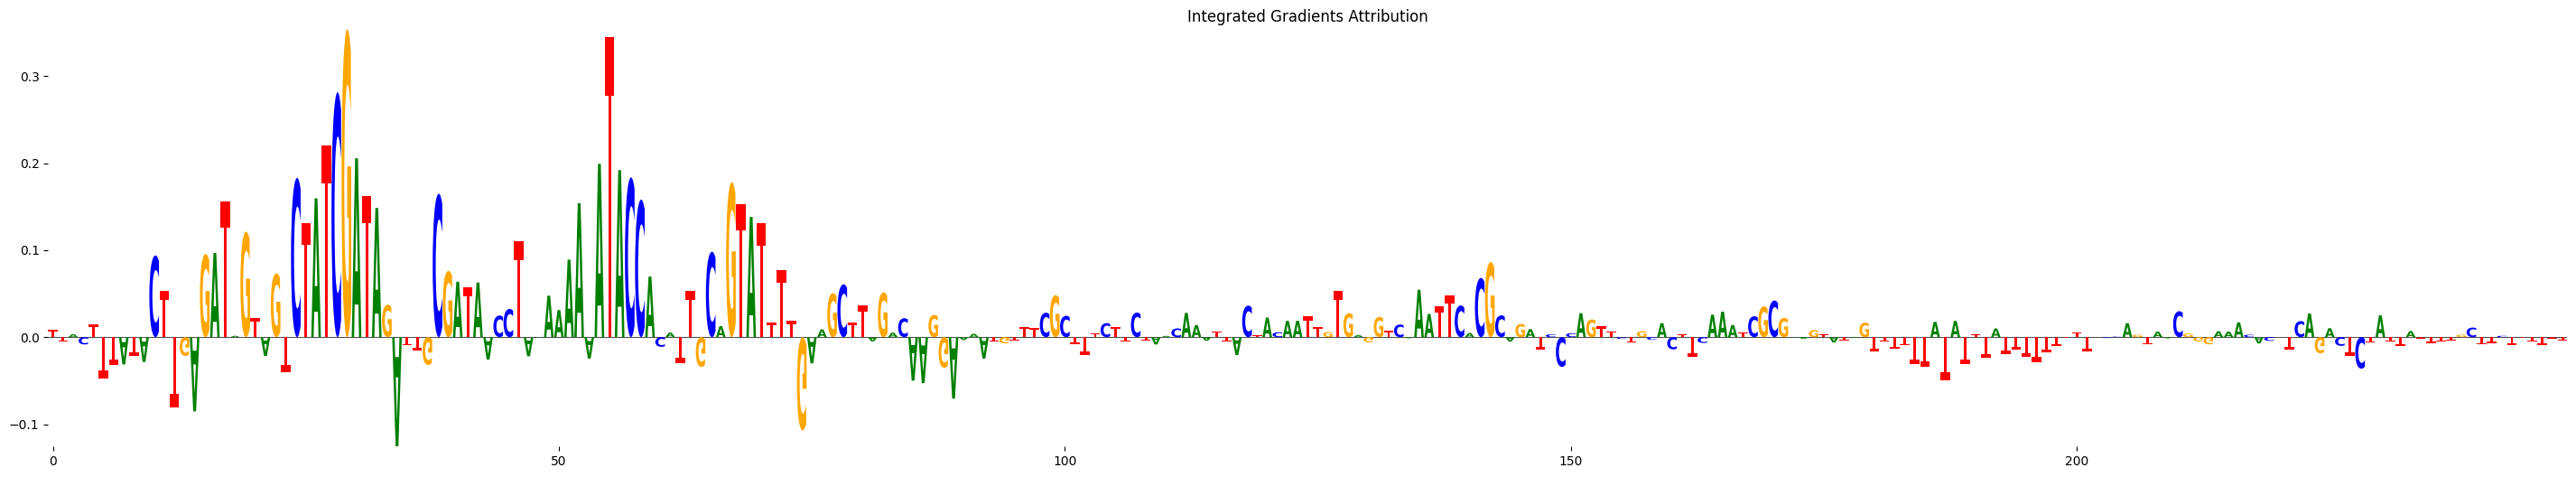

In [138]:
plt.figure(figsize=(36, 6))  # Make it wider (12) and keep height at 6
plot_logo(hk_attributions[0])
plt.title('Integrated Gradients Attribution')